In [1]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv, global_mean_pool
from torch_geometric.data import DataLoader
from torch.utils.data import random_split
from torch_geometric.datasets import TUDataset

# Define GraphSAGE Model
class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return global_mean_pool(x, batch)  # Pool node embeddings into graph embeddings

# Load Dataset
dataset = TUDataset(root='data/TUDataset', name='Mutagenicity')
train_size = int(0.75 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# Initialize Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GraphSAGE(dataset.num_features, 64, 128).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Early Stopping Setup
best_val_loss = float('inf')
patience = 10  # Stop training if no improvement for 10 epochs
patience_counter = 0

# Training Loop with Early Stopping
for epoch in range(10):  # Max epochs
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        embeddings = model(data.x, data.edge_index, data.batch)
        loss = embeddings.norm(p=2, dim=1).mean()  # Dummy loss (modify for specific tasks)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    avg_train_loss = total_loss / len(train_loader)

    # Validation Step
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for data in val_loader:
            data = data.to(device)
            embeddings = model(data.x, data.edge_index, data.batch)
            loss = embeddings.norm(p=2, dim=1).mean()
            val_loss += loss.item()
    avg_val_loss = val_loss / len(val_loader)

    print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}")

    # Early Stopping Logic
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_graphsage_model.pth")  # Save best model
        print("✅ Model improved, saving...")
    else:
        patience_counter += 1
        print(f"⏳ Patience Counter: {patience_counter}/{patience}")
    
    if patience_counter >= patience:
        print("⏹️ Early Stopping Triggered!")
        break

# Load Best Model for Use
model.load_state_dict(torch.load("best_graphsage_model.pth"))
print("🚀 Training Complete. Best model loaded!")


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/opt/anaconda3/envs/gelato/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 1: Train Loss = 0.3356, Val Loss = 0.0678
✅ Model improved, saving...
Epoch 2: Train Loss = 0.0377, Val Loss = 0.0217
✅ Model improved, saving...
Epoch 3: Train Loss = 0.0209, Val Loss = 0.0343
⏳ Patience Counter: 1/10
Epoch 4: Train Loss = 0.0225, Val Loss = 0.0156
✅ Model improved, saving...
Epoch 5: Train Loss = 0.0174, Val Loss = 0.0119
✅ Model improved, saving...
Epoch 6: Train Loss = 0.0143, Val Loss = 0.0160
⏳ Patience Counter: 1/10
Epoch 7: Train Loss = 0.0125, Val Loss = 0.0114
✅ Model improved, saving...
Epoch 8: Train Loss = 0.0102, Val Loss = 0.0087
✅ Model improved, saving...
Epoch 9: Train Loss = 0.0086, Val Loss = 0.0089
⏳ Patience Counter: 1/10
Epoch 10: Train Loss = 0.0077, Val Loss = 0.0081
✅ Model improved, saving...
🚀 Training Complete. Best model loaded!


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)  # First hidden layer
        self.fc2 = nn.Linear(hidden_size, hidden_size)  # Second hidden layer
        self.fc3 = nn.Linear(hidden_size, output_size)  # Output layer

    def forward(self, x):
        x1 = F.relu(self.fc1(x))  # Apply ReLU activation after the first layer
        x2 = F.relu(self.fc2(x1))  # Apply ReLU activation after the second layer
        logits = self.fc3(x2)  # Output layer (raw logits for classification)
        return x1.clone().detach(), x2.clone().detach(), logits

# Example usage:
input_size = 128  # Set input size to 128
hidden_size = 128  # Size of hidden layers
output_size = 2  # Binary classification (two classes)

# Create the MLP model
mlp = MLP(input_size, hidden_size, output_size)

# Define a simple optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()  # For binary or multi-class classification tasks


In [3]:
from edge import EDGE
from edge_estimator import estimate_mi
import numpy as np
from slicing_mi import optimal_SI
def save_MI(I_X_Z1, I_X_Z2, I_Y_Z1, I_Y_Z2, x, z1, z2, y):

    smoothness_vector_xt = np.array([0.8, 1.0, 1.2, 1.8])
    smoothness_vector_ty = np.array([0.4, 0.5, 0.6, 0.8])

    # x = x.cpu().numpy()
    # z1 = z1.cpu().numpy()
    # z2 = z2.cpu().numpy()
    # y = y.cpu().numpy()
    mi_x_z1 = EDGE(x, z1,U=20, L_ensemble=10, gamma=[0.2,  smoothness_vector_xt[0]]) #,U=20, gamma=[0.2,  2*smoothness_vector[layer_idx]], epsilon=[0.2,r*0.2], hashing='p-stable') 
    mi_x_z2 = EDGE(x, z2,U=20, L_ensemble=10, gamma=[0.2,  smoothness_vector_xt[1]]) #,U=20, gamma=[0.2,  2*smoothness_vector[layer_idx]], epsilon=[0.2,r*0.2], hashing='p-stable') 
    mi_z1_y_py = EDGE(y, z1,U=10, L_ensemble=10, gamma=[0.0001, smoothness_vector_ty[0]], epsilon=[0.2,0.2])
    mi_z2_y_py = EDGE(y, z2,U=10, L_ensemble=10, gamma=[0.0001, smoothness_vector_ty[1]], epsilon=[0.2,0.2])

    # mi_x_z1 = estimate_mi(x, z1)
    # mi_x_z2 = estimate_mi(x, z2)
    # mi_z1_y_py = estimate_mi(y, z1)
    # mi_z2_y_py = estimate_mi(y, z2)
    
    I_X_Z1.append(mi_x_z1)
    I_X_Z2.append(mi_x_z2)
    I_Y_Z1.append(mi_z1_y_py)
    I_Y_Z2.append(mi_z2_y_py)
    return 

def save_SI(I_X_Z1, I_X_Z2, I_Y_Z1, I_Y_Z2, x, z1, z2, y):
    x = x.cpu().numpy()
    z1 = z1.cpu().numpy()
    z2 = z2.cpu().numpy()
    y = y.cpu().numpy()
    mi_x_z1 = optimal_SI(x, z1, num_slices=100)
    mi_x_z2 = optimal_SI(x, z2, num_slices=100)
    mi_z1_y_py = optimal_SI(z1, y, num_slices=100)
    mi_z2_y_py = optimal_SI(z2, y, num_slices=100)
    I_X_Z1.append(mi_x_z1)
    I_X_Z2.append(mi_x_z2)
    I_Y_Z1.append(mi_z1_y_py)
    I_Y_Z2.append(mi_z2_y_py)
    return





In [4]:
import torch
import torch.nn.functional as F

# Assume 'model' is the pre-trained graph model (e.g., GraphSAGE) and 'mlp' is your downstream MLP model
# Freeze the weights of the pre-trained model
for param in model.parameters():
    param.requires_grad = False

# Initialize optimizer for the downstream MLP
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Training loop for the MLP
best_val_loss = float('inf')
patience = 1000  # Stop training if no improvement for 10 epochs
patience_counter = 0

I_X_Z1 = []
I_X_Z2 = []

I_Y_Z1 = []
I_Y_Z2 = []

def eval_mlp(mlp, loader):
    # Validation Step
    mlp.eval()  # Set the MLP model to evaluation mode
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():  # No gradient tracking for validation
        for data in loader:
            data = data.to(device)
            with torch.no_grad():
                model.eval()
                embeddings = model(data.x, data.edge_index, data.batch)
            
            z1, z2, outputs = mlp(embeddings)
            
            # Compute the validation loss
            loss = criterion(outputs, data.y)
            val_loss += loss.item()

            # Track accuracy
            _, predicted = outputs.max(1)
            correct += predicted.eq(data.y).sum().item()
            total += data.y.size(0)

    avg_val_loss = val_loss / len(loader)
    val_accuracy = 100. * correct / total
    
    return avg_val_loss, val_accuracy

#TRAINING
for epoch in range(600):  # Max epochs
    mlp.train()  # Set the MLP model to training mode
    total_loss = 0
    correct = 0
    total = 0

    for data in train_loader:
        data = data.to(device)  # Move data to GPU or CPU
        optimizer.zero_grad()

        # Extract embeddings from the pre-trained graph model
        with torch.no_grad():
            model.eval()
            embeddings = model(data.x, data.edge_index, data.batch)  # Freeze model during inference

        # Pass embeddings through the MLP to get predictions
        z1, z2, outputs = mlp(embeddings)
        y_for_MI = data.y.clone().detach().unsqueeze(1)
        

        save_MI(I_X_Z1, I_X_Z2, I_Y_Z1, I_Y_Z2, embeddings.clone().detach(), z1, z2, y_for_MI)
        #save_SI(I_X_Z1, I_X_Z2, I_Y_Z1, I_Y_Z2, embeddings.clone().detach(), z1, z2, y_for_MI)
        # Compute the loss using CrossEntropyLoss
        loss = criterion(outputs, data.y)  # CrossEntropyLoss expects logits and integer labels
        loss.backward()  # Backpropagate the loss
        optimizer.step()  # Update the MLP parameters

        total_loss += loss.item()

        # Track accuracy
        _, predicted = outputs.max(1)
        correct += predicted.eq(data.y).sum().item()
        total += data.y.size(0)

    avg_train_loss = total_loss / len(train_loader)
    train_accuracy = 100. * correct / total

    avg_val_loss, val_accuracy = eval_mlp(mlp, val_loader)

    print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Train Accuracy = {train_accuracy:.2f}%, "
          f"Val Loss = {avg_val_loss:.4f}, Val Accuracy = {val_accuracy:.2f}%")

    # Early Stopping Logic
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save(mlp.state_dict(), "best_mlp_model.pth")  # Save the best MLP model
        print("✅ MLP model improved, saving...")
    else:
        patience_counter += 1
        print(f"⏳ Patience Counter: {patience_counter}/{patience}")
    
    if patience_counter >= patience:
        print("⏹️ Early Stopping Triggered!")
        break

# Load the best MLP model after training
mlp.load_state_dict(torch.load("best_mlp_model.pth"))
mlp.eval()
print("🚀 Training Complete. Best MLP model loaded!")

avg_test_loss, test_accuracy = eval_mlp(mlp, test_loader)

print(f"🏁 Final Test Results: Test Loss = {avg_test_loss:.4f}, Test Accuracy = {test_accuracy:.2f}%")





Epoch 1: Train Loss = 0.6888, Train Accuracy = 55.35%, Val Loss = 0.6835, Val Accuracy = 56.46%
✅ MLP model improved, saving...
Epoch 2: Train Loss = 0.6877, Train Accuracy = 55.35%, Val Loss = 0.6841, Val Accuracy = 56.46%
⏳ Patience Counter: 1/1000
Epoch 3: Train Loss = 0.6875, Train Accuracy = 55.35%, Val Loss = 0.6838, Val Accuracy = 56.46%
⏳ Patience Counter: 2/1000
Epoch 4: Train Loss = 0.6878, Train Accuracy = 55.35%, Val Loss = 0.6840, Val Accuracy = 56.46%
⏳ Patience Counter: 3/1000
Epoch 5: Train Loss = 0.6871, Train Accuracy = 55.35%, Val Loss = 0.6837, Val Accuracy = 56.46%
⏳ Patience Counter: 4/1000


In [7]:
import pickle as pkl
with open('mi_list2.pkl', 'wb') as f:
    pkl.dump((I_X_Z1, I_X_Z2, I_Y_Z1, I_Y_Z2), f)

In [6]:
print(np.__version__)

1.26.4


600 600 600 600


/var/folders/w6/t86vycxs0h3gpp3slqbvnc140000gn/T/ipykernel_24625/3396886531.py:34: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  scatter_Z2 = plt.scatter(I_X_Z2, I_Y_Z2, c=epochs, cmap=cmap, norm=norm, s=50, marker='x', edgecolors='k', alpha=0.7, label="Z2 Layer")


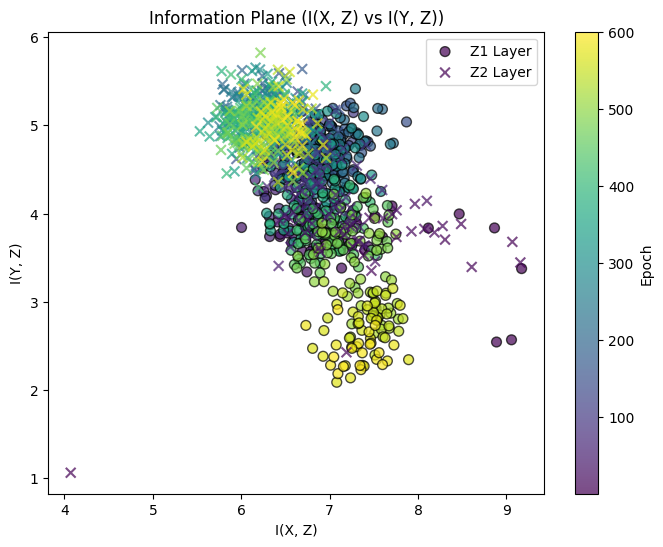

In [37]:
with open('mi_list.pkl', 'rb') as f:
    I_X_Z1, I_X_Z2, I_Y_Z1, I_Y_Z2 = pkl.load(f)

!pip install matplotlib

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Example data (replace with your actual data)
epochs = np.arange(1, 601)  # From epoch 1 to 600

def turn_to_epochs(data):
    return [sum(data[i:i+13]) for i in range(0, len(data), 13)]

I_Y_Z2 = turn_to_epochs(I_Y_Z2)
I_Y_Z1 = turn_to_epochs(I_Y_Z1)
I_X_Z2 = turn_to_epochs(I_X_Z2)
I_X_Z1 = turn_to_epochs(I_X_Z1)

print(len(I_Y_Z1), len(I_Y_Z2), len(I_X_Z1), len(I_X_Z2))


# Create a colormap to represent epochs
norm = plt.Normalize(epochs.min(), epochs.max())
cmap = cm.viridis  # You can change the colormap as you prefer

# Create the plot
plt.figure(figsize=(8, 6))

# Scatter for Z1 layer (color by epoch)
scatter_Z1 = plt.scatter(I_X_Z1, I_Y_Z1, c=epochs, cmap=cmap, norm=norm, s=50, edgecolors='k', alpha=0.7, label="Z1 Layer")

scatter_Z2 = plt.scatter(I_X_Z2, I_Y_Z2, c=epochs, cmap=cmap, norm=norm, s=50, marker='x', edgecolors='k', alpha=0.7, label="Z2 Layer")

# Add color bar
plt.colorbar(scatter_Z1, label='Epoch')

# Labels and title
plt.xlabel('I(X, Z)')
plt.ylabel('I(Y, Z)')
plt.title('Information Plane (I(X, Z) vs I(Y, Z))')

# Legend
plt.legend()

# Show the plot
plt.show()


/var/folders/w6/t86vycxs0h3gpp3slqbvnc140000gn/T/ipykernel_24625/1001780567.py:29: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  scatter_Z2 = plt.scatter(I_X_Z2_new, I_Y_Z2_new, c=epochs_reduced, cmap=cmap, norm=norm, s=50, edgecolors='k', marker='x',alpha=0.7, label="Z2 Layer")


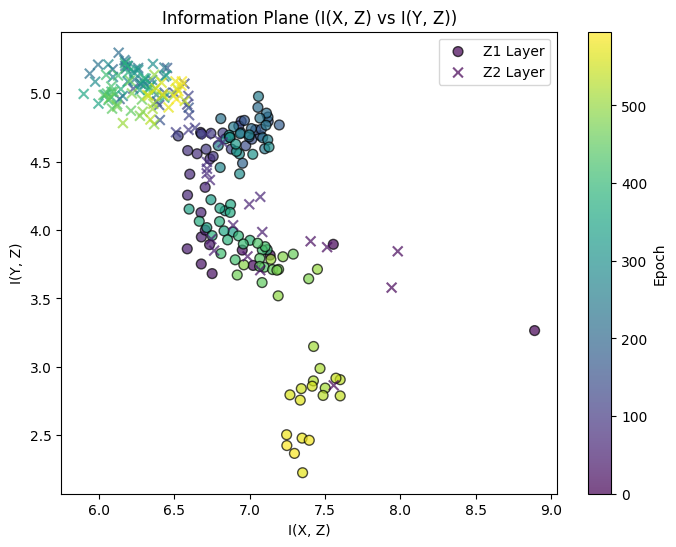

In [38]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm


# Define function to average every 5 epochs
def average_epochs(data, interval=5):
    return [np.mean(data[i:i+interval]) for i in range(0, len(data), interval)]

# Apply averaging
I_Y_Z2_new = average_epochs(I_Y_Z2)
I_Y_Z1_new = average_epochs(I_Y_Z1)
I_X_Z2_new = average_epochs(I_X_Z2)
I_X_Z1_new = average_epochs(I_X_Z1)

# Update epochs to match new reduced data (centers of each 5-epoch interval)
epochs_reduced = np.arange(0, 600, 5)  # Centers of the 5-epoch intervals

# Create a colormap to represent epochs
norm = plt.Normalize(epochs_reduced.min(), epochs_reduced.max())
cmap = cm.viridis

# Create the plot
plt.figure(figsize=(8, 6))

# Scatter for Z1 layer (color by averaged epoch)
scatter_Z1 = plt.scatter(I_X_Z1_new, I_Y_Z1_new, c=epochs_reduced, cmap=cmap, norm=norm, s=50, edgecolors='k', alpha=0.7, label="Z1 Layer")
scatter_Z2 = plt.scatter(I_X_Z2_new, I_Y_Z2_new, c=epochs_reduced, cmap=cmap, norm=norm, s=50, edgecolors='k', marker='x',alpha=0.7, label="Z2 Layer")

# Add color bar
plt.colorbar(scatter_Z1, label='Epoch')

# Labels and title
plt.xlabel('I(X, Z)')
plt.ylabel('I(Y, Z)')
plt.title('Information Plane (I(X, Z) vs I(Y, Z))')

# Legend
plt.legend()

# Show the plot
plt.show()


In [ ]:
optimal_SI(X,Y,num_slices=100)